In [1]:
import pandas
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import geopandas
from collections import defaultdict
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import seaborn as sns
import folium
import glob
from datetime import datetime


# U for Uber, T for T4c, O for OpenStreetMap
START_DAY=1
END_DAY=21 # incl.


# U for Uber, T for T4c
UBASEPATH = Path("/iarai/public/t4c/uber")
TBASEPATH = Path("/iarai/public/t4c/data_pipeline/release20221028_historic_uber")

CITY = "barcelona"
YEAR = 2020
MONTH = 2
START_DAY=1
END_DAY=7 # incl.

# 2020-02-01 Sat
# 2020-02-02 Sun
# 2020-02-03 Mon
# 2020-02-04 Tue
# 2020-02-05 Wed
# 2020-02-06 Thu
# 2020-02-07 Fri

DAYTIME_START_HOUR=8
DAYTIME_END_HOUR=18
DAYTIME_HOURS = DAYTIME_END_HOUR - DAYTIME_START_HOUR

In [2]:
highway_ordering = [
    'motorway', 'motorway_link', 
    'trunk','trunk_link', 
    'primary','primary_link',
    'secondary', 'secondary_link', 
    'tertiary','tertiary_link',
    'unclassified',  'residential',
    'living_street', 'service',
    'cycleway', 'road', 'construction'
]

In [3]:
simplified_filter = lambda hw: hw not in ['residential', 'living_street', 'service', 'road']

# Load Uber data

In [4]:
uspeeds_df = pandas.read_parquet(UBASEPATH / f'movement-speeds-hourly-{CITY}-{YEAR}-{MONTH}.parquet' )
uspeeds_df = uspeeds_df[(uspeeds_df["day"]>=START_DAY)&(uspeeds_df["day"]<=END_DAY)]
# uspeeds_df['speed_kph_mean'] = uspeeds_df['speed_mph_mean'] * 1.60934
uspeeds_df = uspeeds_df.rename(columns={'osm_start_node_id': 'u', 'osm_end_node_id': 'v', "osm_way_id": "osmid"})
uspeeds_df["gkey"] = [ f"{u}_{v}_{osmid}" for u,v,osmid in zip(uspeeds_df["u"],uspeeds_df["v"],uspeeds_df["osmid"])]
uspeeds_df.shape

(10477, 14)

# Load IARAI speed between 2020-2-1 and 2020-2-8

In [5]:
tspeeds_l = []
for i in range(START_DAY,END_DAY+1):
    f = TBASEPATH / 'speed_classes' / CITY / f'speed_classes_{YEAR}-{str(MONTH).zfill(2)}-{str(i).zfill(2)}.parquet'
    print(f)
    df = pd.read_parquet(f)
    df["date"]=df["day"]
    df["year"]= YEAR
    df["month"]= MONTH
    df["day"]=i
    df["hour"]= df["t"]//4
    df = df[['u', 'v', 'gkey','year', 'month',
            'day', 'hour', 'volume', 'volume_class', 'median_speed_kph', 
            'free_flow_kph', 'std_speed_kph']].groupby(
    by=['u', 'v', 'gkey','year', 'month', 'day','hour']).agg(
        volume_class=("volume_class", "mean"),
        volume=("volume", "mean"),
        std_speed_kph=("std_speed_kph", "mean"),
        median_speed_kph=("median_speed_kph", "mean"),
        free_flow_kph=("free_flow_kph", "first")
    ).reset_index()
    tspeeds_l.append(df)
tspeeds_df = pandas.concat(tspeeds_l)
tspeeds_df.shape

/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/barcelona/speed_classes_2020-02-01.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/barcelona/speed_classes_2020-02-02.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/barcelona/speed_classes_2020-02-03.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/barcelona/speed_classes_2020-02-04.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/barcelona/speed_classes_2020-02-05.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/barcelona/speed_classes_2020-02-06.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/barcelona/speed_classes_2020-02-07.parquet


(423263, 12)

In [6]:
gdf_nodes = gpd.read_parquet(TBASEPATH / "road_graph" / CITY / "road_graph_nodes.parquet")
gdf_edges = gpd.read_parquet(TBASEPATH / "road_graph" / CITY / "road_graph_edges.parquet")

In [7]:
gdf_edges = gdf_edges.merge(gdf_nodes, 
                            left_on="u", 
                            right_on="node_id", 
                            suffixes=["","_u"]).merge(gdf_nodes, 
                                                     left_on="v", 
                                                     right_on="node_id", 
                                                     suffixes=["","_v"])
gdf_edges.rename(columns={"x":"x_u", "y":"y_u"}, inplace=True)
del gdf_edges["geometry_u"]
del gdf_edges["geometry_v"]
gdf_edges.shape

(5943, 19)

In [8]:
# Barcelona
y_min,y_max,x_min,x_max = 41.25300, 41.74800, 1.92500, 2.36100

def in_bb(x,y):
    return (x_min <= x <= x_max) and (y_min <= y <= y_max)

# in the spatial coverage, within London is defined as either u or v is within the bounding box

gdf_edges["in_bb"] = [(in_bb(x_u,y_u) or in_bb(x_v,y_v)) for x_u,y_u,x_v,y_v 
                                in zip(gdf_edges["x_u"], gdf_edges["y_u"],
                                        gdf_edges["x_v"], gdf_edges["y_v"])]

In [9]:
gdf_edges[gdf_edges["in_bb"]==True].groupby('highway').size()

highway
living_street       24
motorway            16
motorway_link        3
primary            709
primary_link       216
residential       1341
secondary         1278
secondary_link      92
tertiary          2014
tertiary_link      130
trunk               56
trunk_link          44
unclassified        20
dtype: int64

In [10]:
gdf_edges = gdf_edges[gdf_edges["in_bb"]==True]

In [11]:
ut_merged = uspeeds_df.merge(tspeeds_df, on=['u', 'v', 'gkey','year', 
                                    'month','day', 'hour']).merge(gdf_edges, on=["u","v","gkey"])
ut_merged.head()

,year,month,day,hour,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid_x,u,...,length_meters,geometry,name,node_id,x_u,y_u,node_id_v,x_v,y_v,in_bb
0,2020,2,7,21,2020-02-07T20:00:00.000Z,2c72d02f0a169894a1ab1c518761cc8ed782671e,cff3a52a4c4b3b4051e51519d8a9724c8823aa33,1bf52f16a370a1b42048ffa6d7db90c6df416190,237659851,30238017,...,149.211483,"LINESTRING (2.14598 41.38310, 2.14583 41.38321...",Carrer d'Entença,30238017,2.145985,41.383100,30246860,2.144917,41.383913,True
1,2020,2,2,20,2020-02-02T19:00:00.000Z,1040695f92a242373f3aecdebe72ff89bafa9448,3d934ee0aac26e2c4c8bac0c47d9020b8a34a0c9,b67d7ad1f8a490139841b25fa5dd89a24d1853f5,527891899,2862694801,...,45.426486,"LINESTRING (2.04203 41.33371, 2.04178 41.33390...",Ronda de Sant Ramon,2862694801,2.042034,41.333714,510826052,2.041707,41.333958,True
2,2020,2,7,22,2020-02-07T21:00:00.000Z,104215d848d7e156d934d2cc233d7a5f7bf0e929,d50e192441bd05eb20b88b73e37bebc4bd40f685,d92f347d6d9541bb0f74867f7c29702fbbd993e2,561549331,1390694381,...,8.872127,"LINESTRING (2.06885 41.47844, 2.06884 41.47843...",,1390694381,2.068852,41.478437,1390694013,2.068775,41.478415,True
3,2020,2,1,20,2020-02-01T19:00:00.000Z,104215d848d7e156d934d2cc233d7a5f7bf0e929,d50e192441bd05eb20b88b73e37bebc4bd40f685,d92f347d6d9541bb0f74867f7c29702fbbd993e2,561549331,1390694381,...,8.872127,"LINESTRING (2.06885 41.47844, 2.06884 41.47843...",,1390694381,2.068852,41.478437,1390694013,2.068775,41.478415,True
4,2020,2,1,13,2020-02-01T12:00:00.000Z,104215d848d7e156d934d2cc233d7a5f7bf0e929,d50e192441bd05eb20b88b73e37bebc4bd40f685,d92f347d6d9541bb0f74867f7c29702fbbd993e2,561549331,1390694381,...,8.872127,"LINESTRING (2.06885 41.47844, 2.06884 41.47843...",,1390694381,2.068852,41.478437,1390694013,2.068775,41.478415,True


In [12]:
ut_merged["speed_diff"] = ut_merged["median_speed_kph"]-ut_merged["speed_kph_mean"]
ut_merged["sort_key"] = [highway_ordering.index(hw) for hw in ut_merged["highway"]]
ut_merged = ut_merged.sort_values("sort_key")

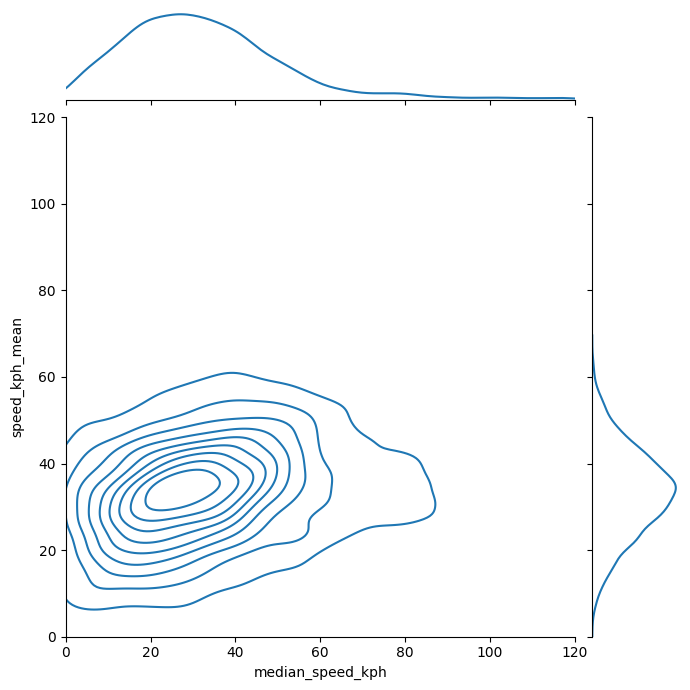

In [13]:
g = sns.jointplot(x="median_speed_kph", y="speed_kph_mean", data=ut_merged,
                  kind="kde", 
                  xlim=(0, 120), ylim=(0, 120),
                  height=7,
                  palette=sns.color_palette('Set2'))

# Stats of road segment matching  

In [14]:
def osm_color_palette():
    for c in ["#115f9a", "#22a7f0", 
                "#991f17", "#df8879", 
                "#48446e", "#9080ff", 
                "#a57c1b", "#ffb400"] + ["white"] * 99:
        yield c

In [15]:
# time label
ut_merged['date'] = pd.to_datetime(ut_merged[['year', 'month', 'day']])
ut_merged['date_hour'] = ut_merged['date'] + pd.to_timedelta(ut_merged['hour'], "hours")
ut_merged = ut_merged.sort_values(['date_hour', "sort_key"])

In [16]:
tspeeds_df['date'] = pd.to_datetime(tspeeds_df[['year', 'month', 'day']])
tspeeds_df['date_hour'] = tspeeds_df['date'] + pd.to_timedelta(tspeeds_df['hour'], "hours")
tspeeds_df = tspeeds_df.merge(gdf_edges, on=["u","v","gkey"])
tspeeds_df["sort_key"] = [highway_ordering.index(hw) for hw in tspeeds_df["highway"]]
tspeeds_df = tspeeds_df.sort_values("sort_key")
tspeeds_df = tspeeds_df.sort_values(['date_hour', "sort_key"])

In [17]:
uspeeds_df['date'] = pd.to_datetime(uspeeds_df[['year', 'month', 'day']])
uspeeds_df['date_hour'] = uspeeds_df['date'] + pd.to_timedelta(uspeeds_df['hour'], "hours")
uspeeds_df = uspeeds_df.merge(gdf_edges, on=["u","v","gkey"])
uspeeds_df["sort_key"] = [highway_ordering.index(hw) for hw in uspeeds_df["highway"]]
uspeeds_df = uspeeds_df.sort_values("sort_key")
uspeeds_df = uspeeds_df.sort_values(['date_hour', "sort_key"])

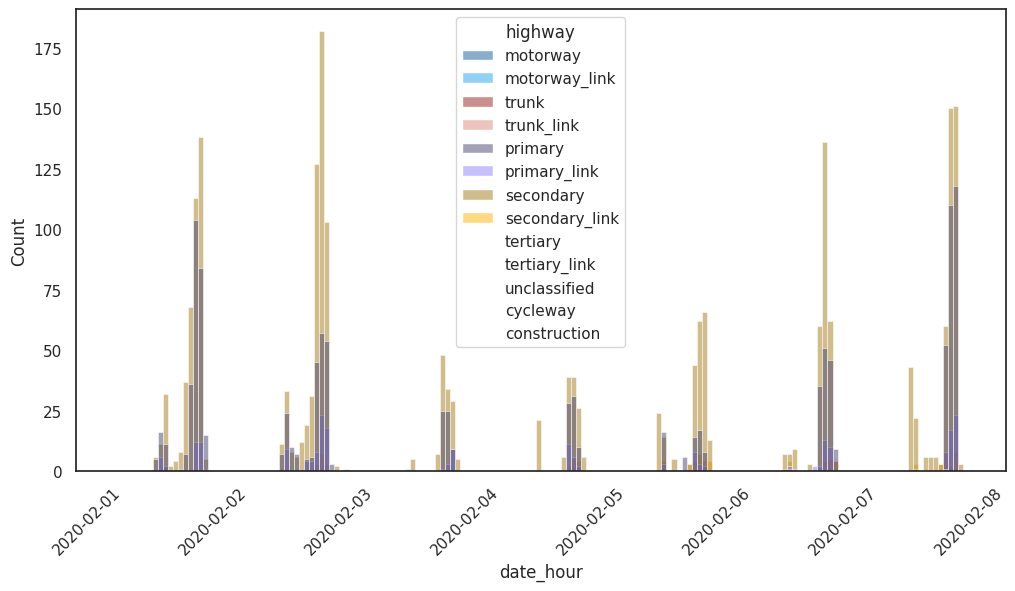

In [18]:
sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style("white")

g = sns.histplot(data = ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]],
                 x='date_hour', hue="highway", 
                 hue_order= [hw for hw in highway_ordering if simplified_filter(hw)], 
                 palette=osm_color_palette(),
                 bins= 7*24
                 )
plt.xticks(rotation=45)
plt.show()

In [19]:
tspeeds_hourly_count = tspeeds_df.groupby(['u', 'v', 'gkey', 'date_hour']).size().reset_index(name='count')
uspeeds_hourly_count = uspeeds_df.groupby(['u', 'v', 'gkey', 'date_hour']).size().reset_index(name='count')
matched_hourly_count = ut_merged.groupby(['u', 'v', 'gkey', 'date_hour']).size().reset_index(name='count')

In [20]:
tspeeds_hourly_count['label'] = 'mcswts'
uspeeds_hourly_count['label'] = 'uber'
matched_hourly_count['label'] = 'matched'
hourly_count = pd.concat([tspeeds_hourly_count, uspeeds_hourly_count, matched_hourly_count])

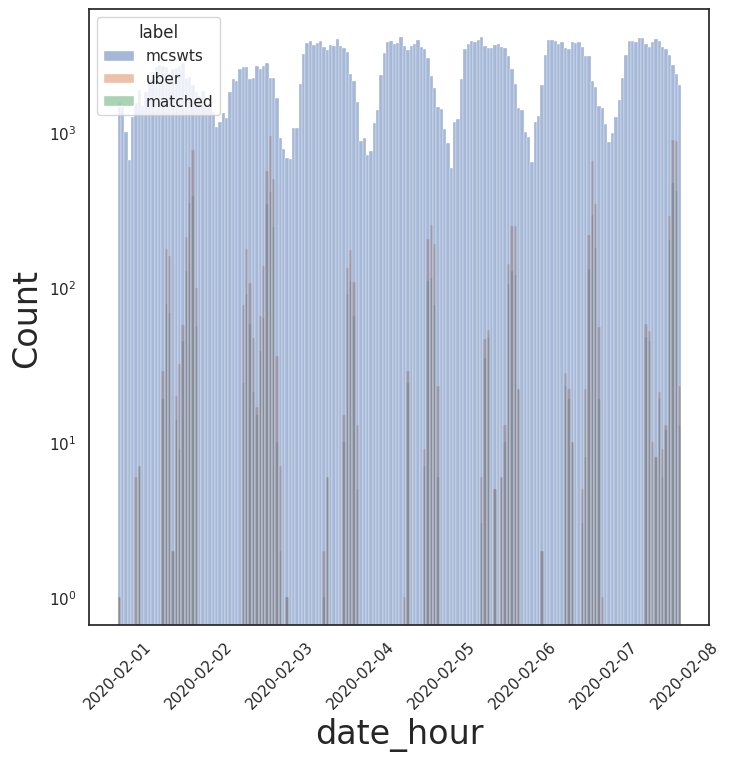

In [21]:
sns.set(rc={'figure.figsize':(8, 8)})
sns.set_style("white")
plt.rcParams["axes.labelsize"] = 24

g = sns.histplot(
    hourly_count, x="date_hour", 
    hue="label", 
    log_scale=(False, True),
    bins=24*7
)
plt.xticks(rotation=45)
plt.show()

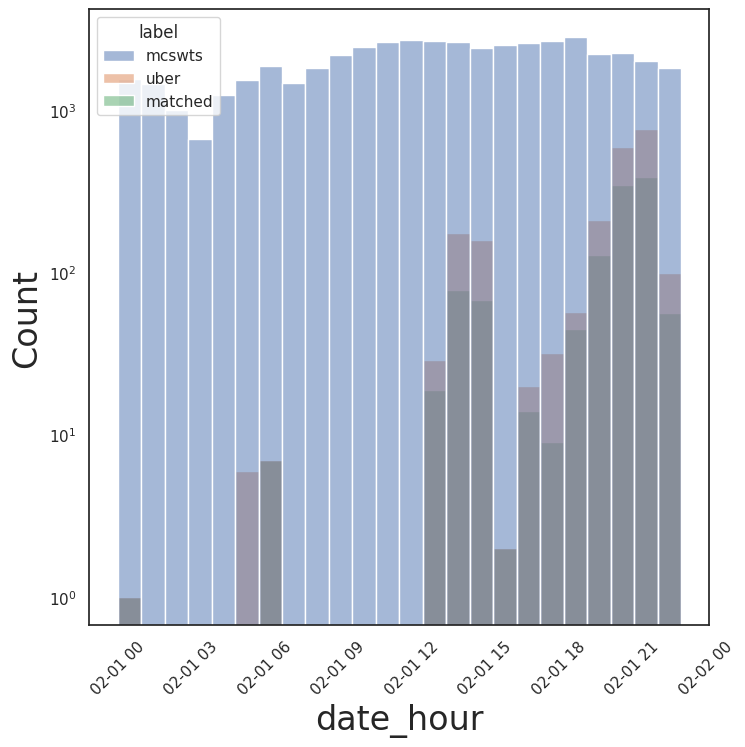

In [22]:
sns.set(rc={'figure.figsize':(8, 8)})
sns.set_style("white")
plt.rcParams["axes.labelsize"] = 24

g = sns.histplot(
    hourly_count[(hourly_count['date_hour'] >= datetime(YEAR, MONTH, START_DAY)) & 
                (hourly_count['date_hour'] < datetime(YEAR, MONTH, START_DAY + 1))], x="date_hour", 
    hue="label", 
    log_scale=(False, True),
    bins=24
)
plt.xticks(rotation=45)
plt.show()

In [23]:
tspeeds_highway_hourly_count = tspeeds_hourly_count.merge(gdf_edges[["u", "v", "gkey", "highway"]], 
                                                                    on=["u","v","gkey"])
uspeeds_highway_hourly_count = uspeeds_hourly_count.merge(gdf_edges[["u", "v", "gkey", "highway"]], 
                                                                    on=["u","v","gkey"])
matched_highway_hourly_count = matched_hourly_count.merge(gdf_edges[["u", "v", "gkey", "highway"]], 
                                                                    on=["u","v","gkey"])

In [24]:
tspeeds_highway_hourly_sum = tspeeds_highway_hourly_count[[simplified_filter(hw) for hw 
                                                                in tspeeds_highway_hourly_count["highway"]]]\
                            .groupby(["highway", "date_hour"]).agg({"count": sum})\
                            .reset_index()

/tmp/ipykernel_39416/3769754942.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (tspeeds_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_39416/3769754942.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (tspeeds_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_39416/3769754942.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (tspeeds_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_39416/3769754942.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (tspeeds_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "d

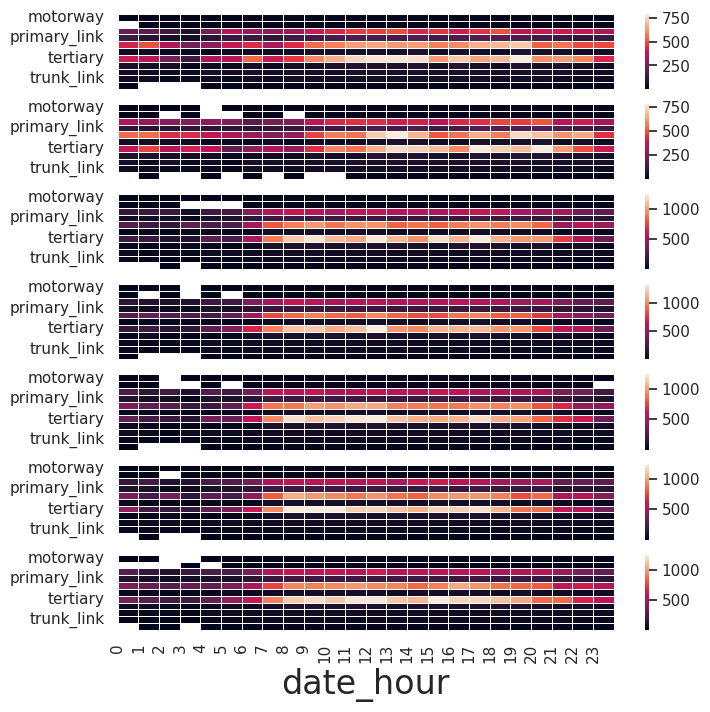

In [25]:
fig, axes = plt.subplots(nrows=7, ncols=1)

for idx, day in enumerate(range(START_DAY, END_DAY + 1)):
    ax = axes[idx]
    tspeeds_highway_hourly_sum_pivot = \
            tspeeds_highway_hourly_sum[(tspeeds_highway_hourly_sum['date_hour'] >= datetime(YEAR, MONTH, day)) & 
            (tspeeds_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour", "count")
    g = sns.heatmap(tspeeds_highway_hourly_sum_pivot, linewidths=.5, ax=ax)
    if idx < 6:
        g.set(xticklabels=[])
    else:
        g.set(xticks=range(24), xticklabels=[str(i) for i in range(24)])
    g.set(ylabel=None)

In [26]:
uspeeds_highway_hourly_sum = uspeeds_highway_hourly_count[[simplified_filter(hw) for hw 
                                                                in uspeeds_highway_hourly_count["highway"]]]\
                            .groupby(["highway", "date_hour"]).agg({"count": sum})\
                            .reset_index()

/tmp/ipykernel_39416/82016574.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (uspeeds_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_39416/82016574.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (uspeeds_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_39416/82016574.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (uspeeds_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_39416/82016574.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (uspeeds_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour

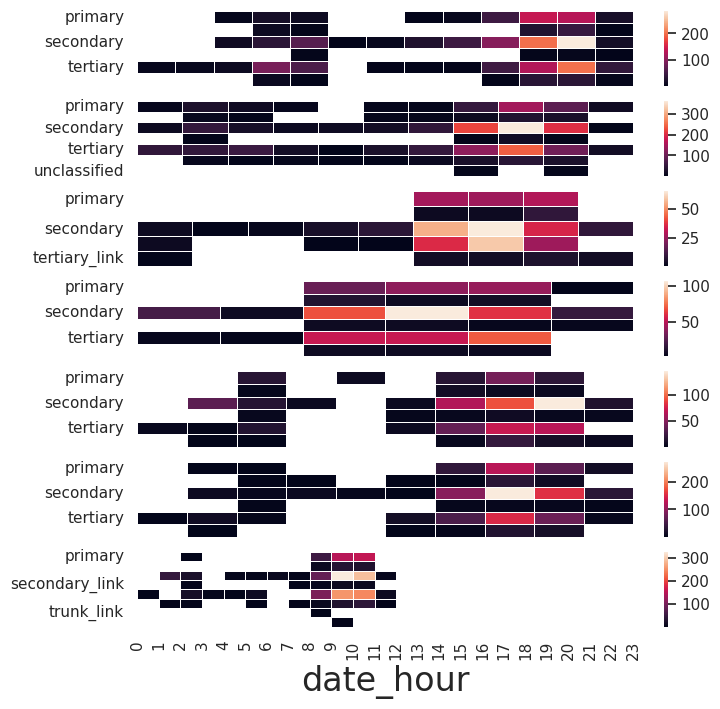

In [27]:
fig, axes = plt.subplots(nrows=7, ncols=1)

for idx, day in enumerate(range(START_DAY, END_DAY + 1)):
    ax = axes[idx]
    uspeeds_highway_hourly_sum_pivot = \
            uspeeds_highway_hourly_sum[(uspeeds_highway_hourly_sum['date_hour'] >= datetime(YEAR, MONTH, day)) & 
            (uspeeds_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour", "count")
    g = sns.heatmap(uspeeds_highway_hourly_sum_pivot, linewidths=.5, ax=ax)
    if idx < 6:
        g.set(xticklabels=[])
    else:
        g.set(xticks=range(24), xticklabels=[str(i) for i in range(24)])
    g.set(ylabel=None)

In [28]:
matched_highway_hourly_sum = matched_highway_hourly_count[[simplified_filter(hw) for hw 
                                                                in matched_highway_hourly_count["highway"]]]\
                            .groupby(["highway", "date_hour"]).agg({"count": sum})\
                            .reset_index()

/tmp/ipykernel_39416/4113610259.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (matched_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_39416/4113610259.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (matched_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_39416/4113610259.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (matched_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_39416/4113610259.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (matched_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "d

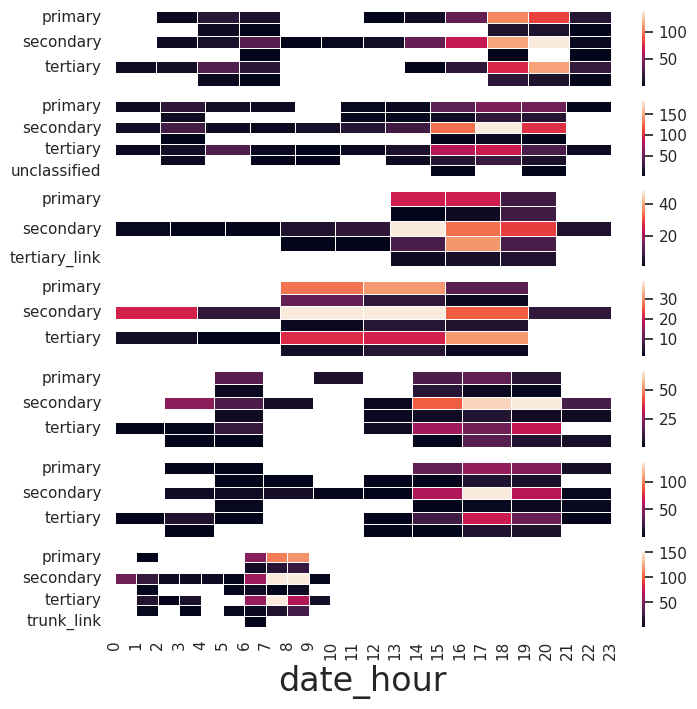

In [29]:
fig, axes = plt.subplots(nrows=7, ncols=1)

for idx, day in enumerate(range(START_DAY, END_DAY + 1)):
    ax = axes[idx]
    matched_highway_hourly_sum_pivot = \
            matched_highway_hourly_sum[(matched_highway_hourly_sum['date_hour'] >= datetime(YEAR, MONTH, day)) & 
            (matched_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour", "count")
    g = sns.heatmap(matched_highway_hourly_sum_pivot, linewidths=.5, ax=ax)
    if idx < 6:
        g.set(xticklabels=[])
    else:
        g.set(xticks=range(24), xticklabels=[str(i) for i in range(24)])
    g.set(ylabel=None)

# Speed difference analysis

In [30]:
ut_merged['median_uber_diff'] = ut_merged['median_speed_kph'] - ut_merged['speed_kph_mean'] 

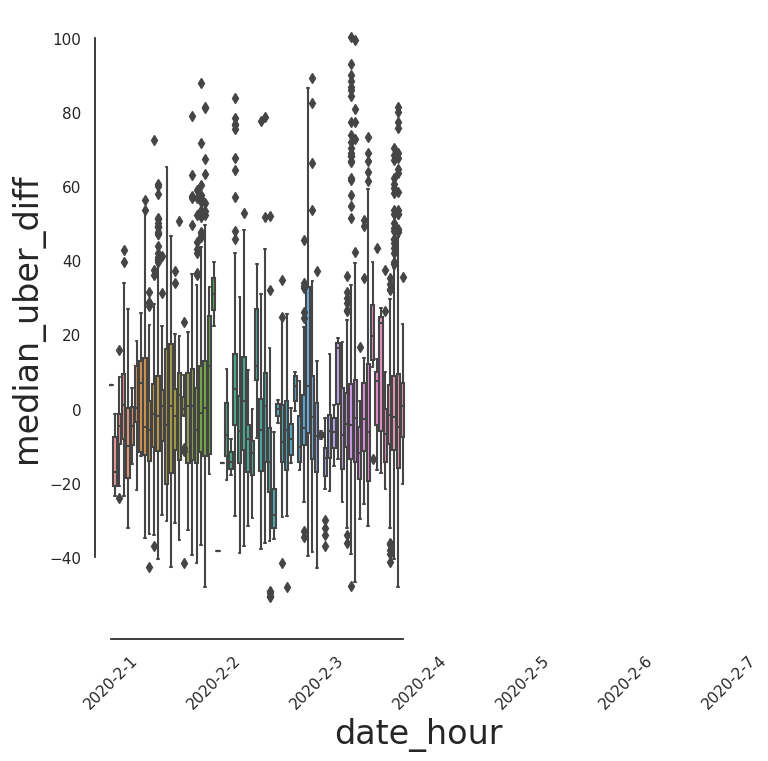

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))

g = sns.boxplot(x="date_hour", y="median_uber_diff",
            data=ut_merged, ax = ax)
sns.despine(offset=10, trim=True)

ax.set_xticks(range(0, 24 * 7, 24))
ax.set_xticklabels([f"{YEAR}-{MONTH}-{i}" for i in range(START_DAY, END_DAY + 1)])
plt.xticks(rotation=45)

plt.show()

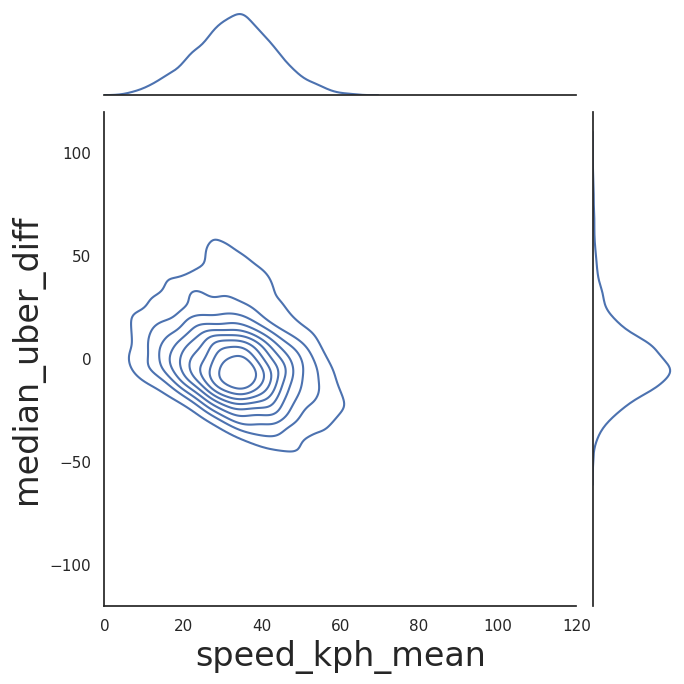

In [32]:
g = sns.jointplot(x="speed_kph_mean", y="median_uber_diff", data=ut_merged,
                  kind="kde", 
                  xlim=(0, 120), ylim=(-120, 120),
                  height=7, 
                  palette=sns.color_palette('Set2'))

## speed difference by time and road types

In [33]:
speed_diff_highway_hourly = ut_merged.groupby(["highway", "hour"])\
            .agg({'median_uber_diff': ['mean', 'count']}).reset_index()
speed_diff_highway_hourly.columns = ["highway", "hour", "speed_diff", "count"]

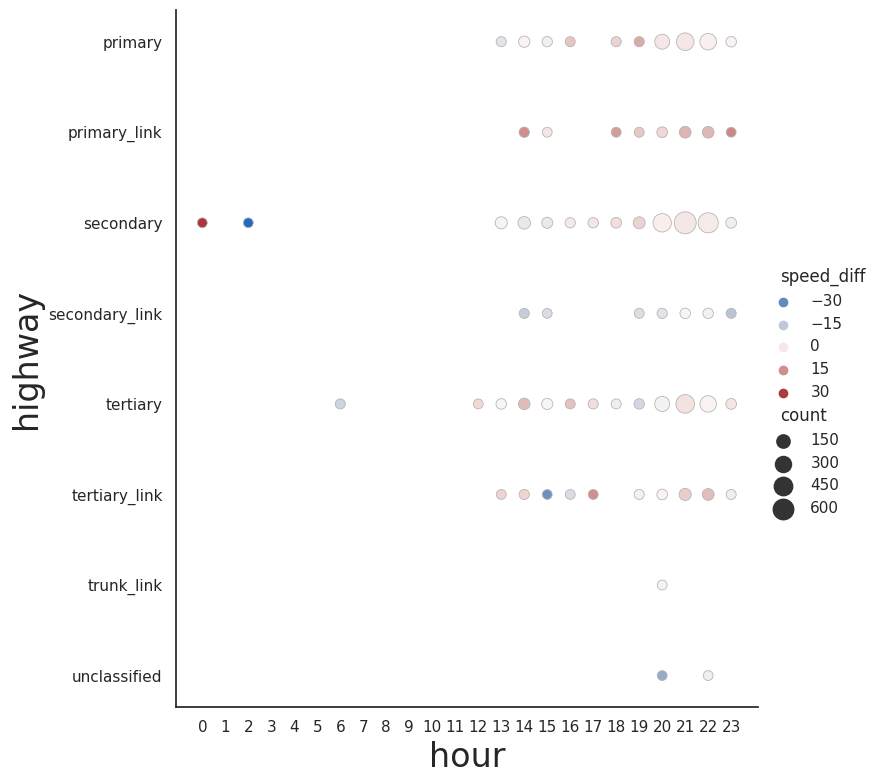

In [34]:
# here the hue refers to the mean of aggreagted speed diff by hour

g = sns.relplot(
    data=speed_diff_highway_hourly[[simplified_filter(hw) for hw in speed_diff_highway_hourly["highway"]]],
    x="hour", y="highway", hue="speed_diff", size="count",
    palette="vlag", edgecolor=".7",
    height=8, sizes=(50, 250), 
)
g.set(xticks= range(24))

## extreme difference by time

In [35]:
ut_merged['median_uber_diff'].quantile(q=0.975), ut_merged['median_uber_diff'].quantile(q=0.025)

(47.39803382352942, -31.593833823529415)

In [36]:
big_pos_div = ut_merged[ut_merged['median_uber_diff'] > ut_merged['median_uber_diff'].quantile(q=0.975)]
big_neg_div = ut_merged[ut_merged['median_uber_diff'] < ut_merged['median_uber_diff'].quantile(q=0.025)]

In [37]:
ut_hourly_matched = ut_merged.groupby('date_hour').size().reset_index(name='count')
big_pos_div_hourly = big_pos_div.groupby('date_hour').size().reset_index(name='count')
big_neg_div_hourly = big_neg_div.groupby('date_hour').size().reset_index(name='count')
hourly_matched = ut_hourly_matched.merge(big_pos_div_hourly, suffixes=["","_pos"], on='date_hour')\
                                    .merge(big_neg_div_hourly, suffixes=["","_neg"], on='date_hour')

In [38]:
hourly_matched['pos_prop'] = hourly_matched['count_pos'] / hourly_matched['count']
hourly_matched['neg_prop'] = hourly_matched['count_neg'] / hourly_matched['count']

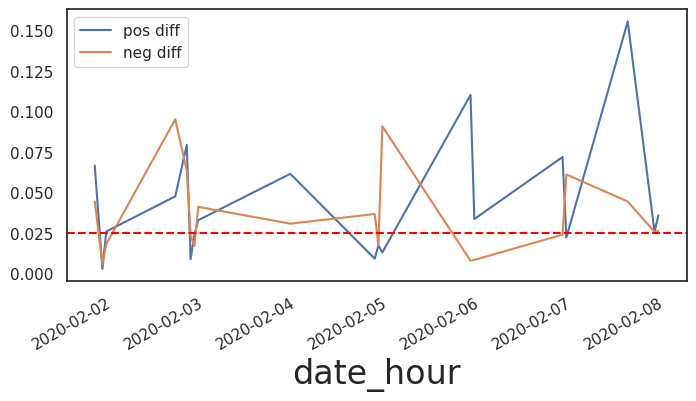

In [39]:
fig, ax = plt.subplots(figsize=(8, 4))

g = hourly_matched.plot(x='date_hour', y="pos_prop", ax=ax, label='pos diff')
g = hourly_matched.plot(x='date_hour', y="neg_prop", ax=ax, label='neg diff')

plt.axhline(0.025, color='red', linestyle='--')
plt.show()

In [40]:
hourly_matched['hour'] = hourly_matched['date_hour'].dt.hour

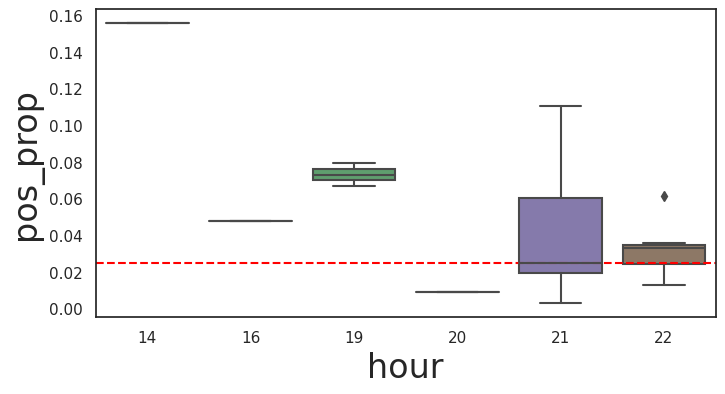

In [41]:
fig, ax = plt.subplots(figsize=(8, 4))

g = sns.boxplot(hourly_matched, x= 'hour', y="pos_prop", ax=ax)

plt.axhline(0.025, color='red', linestyle='--')
plt.show()

Are there segments always having big speed difference?

In [42]:
pos_seg_counts = big_pos_div.groupby(["u", "v", "gkey"]).\
                        agg({'date_hour': 'count'}).reset_index()
neg_seg_counts = big_neg_div.groupby(["u", "v", "gkey"]).\
                        agg({'date_hour': 'count'}).reset_index()

In [43]:
pos_seg_counts['date_hour'].describe()

count    131.000000
mean       1.053435
std        0.225763
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: date_hour, dtype: float64

In [44]:
neg_seg_counts['date_hour'].describe()

count    132.000000
mean       1.045455
std        0.209092
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: date_hour, dtype: float64

In [45]:
pos_seg_counts = pos_seg_counts.sort_values("date_hour", ascending=False)
neg_seg_counts = neg_seg_counts.sort_values("date_hour", ascending=False)

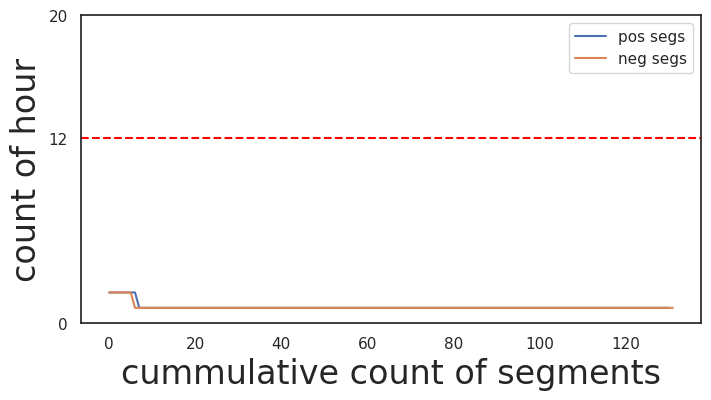

In [46]:
fig, ax = plt.subplots(figsize=(8, 4))

g = ax.plot(range(pos_seg_counts.shape[0]), pos_seg_counts.date_hour, label='pos segs')
g = ax.plot(range(neg_seg_counts.shape[0]), neg_seg_counts.date_hour, label='neg segs')
ax.set_ylabel('count of hour')
ax.set_xlabel('cummulative count of segments')

ax.set_yticks(list(range(0, 40, 20)) + [12])

plt.axhline(12, color='red', linestyle='--')
plt.legend()
plt.show()

In [47]:
pos_seg_counts.sort_values("date_hour", ascending=False)

,u,v,gkey,date_hour
27,71643529,559765972,71643529_559765972_491443474,2
81,1357271796,331355856,1357271796_331355856_121189298,2
15,30254395,30254220,30254395_30254220_237725945,2
6,30243244,2819073911,30243244_2819073911_309896347,2
118,5249411005,415950287,5249411005_415950287_237652086,2
...,...,...,...,...
126,5402582937,50099103,5402582937_50099103_140001512,1
127,5405788370,5264791964,5405788370_5264791964_249808253,1
128,6099715648,1375265209,6099715648_1375265209_238862113,1
129,6356691517,30247402,6356691517_30247402_287683998,1


In [48]:
# worst case 

s_u, s_v, s_gkey, s_dh = pos_seg_counts.sort_values("date_hour", ascending=False).iloc[0]

sample_big_pos_div = ut_merged[(ut_merged['u'] == s_u) & (ut_merged['v'] == s_v) 
            & (ut_merged['gkey'] == s_gkey)] 

s_seg = gdf_edges[(gdf_edges['u'] == s_u) & (gdf_edges['v'] == s_v) 
            & (gdf_edges['gkey'] == s_gkey)]

In [49]:
s_map = folium.Map(location = (s_seg['geometry'].centroid.y, 
                                s_seg['geometry'].centroid.x), zoom_start = 16)
s_j = s_seg['geometry'].to_json()
s_j = folium.GeoJson(data=s_j, style_function=lambda x: {'color': 'red'})
s_j.add_to(s_map)

s_map

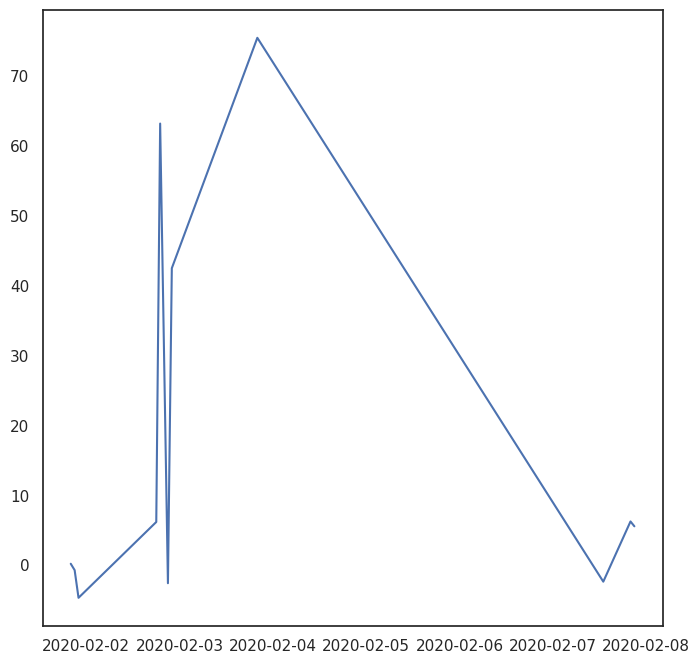

In [50]:
plt.plot(sample_big_pos_div["date_hour"], sample_big_pos_div["median_uber_diff"])

In [51]:
# worst case 

s_u, s_v, s_gkey, s_dh = neg_seg_counts.sort_values("date_hour", ascending=False).iloc[0]

sample_big_neg_div = ut_merged[(ut_merged['u'] == s_u) & (ut_merged['v'] == s_v) 
            & (ut_merged['gkey'] == s_gkey)] 

s_seg = gdf_edges[(gdf_edges['u'] == s_u) & (gdf_edges['v'] == s_v) 
            & (gdf_edges['gkey'] == s_gkey)]

In [52]:
s_map = folium.Map(location = (s_seg['geometry'].centroid.y, 
                                s_seg['geometry'].centroid.x), zoom_start = 16)
s_j = s_seg['geometry'].to_json()
s_j = folium.GeoJson(data=s_j, style_function=lambda x: {'color': 'red'})
s_j.add_to(s_map)
s_map

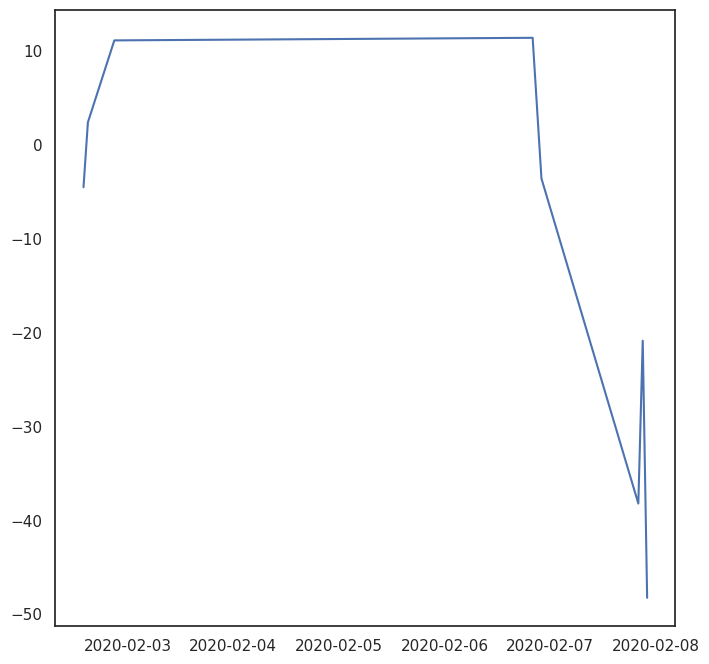

In [53]:
plt.plot(sample_big_neg_div["date_hour"], sample_big_neg_div["median_uber_diff"])

In [54]:
pos_seg_counts[pos_seg_counts["date_hour"] > 12].shape, neg_seg_counts[neg_seg_counts["date_hour"] > 12].shape

((0, 4), (0, 4))

In [55]:
pos_neg_seg_counts = pos_seg_counts.merge(neg_seg_counts, on=["u", "v", "gkey"], how='inner', suffixes=["_pos","_neg"])
print(pos_neg_seg_counts.shape, pos_seg_counts.shape, neg_seg_counts.shape)

(14, 5) (131, 4) (132, 4)


In [56]:
pos_neg_seg_counts['overlap_hour'] = pos_neg_seg_counts[pos_neg_seg_counts['date_hour_pos'] 
                                                        < pos_neg_seg_counts['date_hour_neg']]['date_hour_pos']
pos_neg_seg_counts['overlap_hour'] = pos_neg_seg_counts[pos_neg_seg_counts['date_hour_pos'] 
                                                        >= pos_neg_seg_counts['date_hour_neg']]['date_hour_neg']

In [57]:
pos_neg_seg_counts['overlap_hour'].max()

1.0

In [58]:
seg_highway_counts = gdf_edges.groupby('highway').size().reset_index(name='count')

In [59]:
# It is # of segments
pos_seg_highway_counts = pos_seg_counts.merge(gdf_edges, on=['u', 'v', 'gkey'], 
                                            how='left').groupby('highway').size().reset_index(name='count')

In [60]:
pos_seg_highway_counts = pos_seg_highway_counts.merge(seg_highway_counts, on='highway', 
                                                        suffixes=['_pos', '_all'])
pos_seg_highway_counts['prop'] = pos_seg_highway_counts['count_pos'] / pos_seg_highway_counts['count_all']

In [61]:
neg_seg_highway_counts = neg_seg_counts.merge(gdf_edges, on=['u', 'v', 'gkey'], 
                                            how='left').groupby('highway').size().reset_index(name='count')

In [62]:
neg_seg_highway_counts = neg_seg_highway_counts.merge(seg_highway_counts, on='highway', 
                                                        suffixes=['_pos', '_all'])
neg_seg_highway_counts['prop'] = neg_seg_highway_counts['count_pos'] / neg_seg_highway_counts['count_all']

In [63]:
pos_seg_highway_counts['label'] = 'pos'
neg_seg_highway_counts['label'] = 'neg'

In [64]:
pos_neg_highway = pd.concat([pos_seg_highway_counts, neg_seg_highway_counts], axis=0)

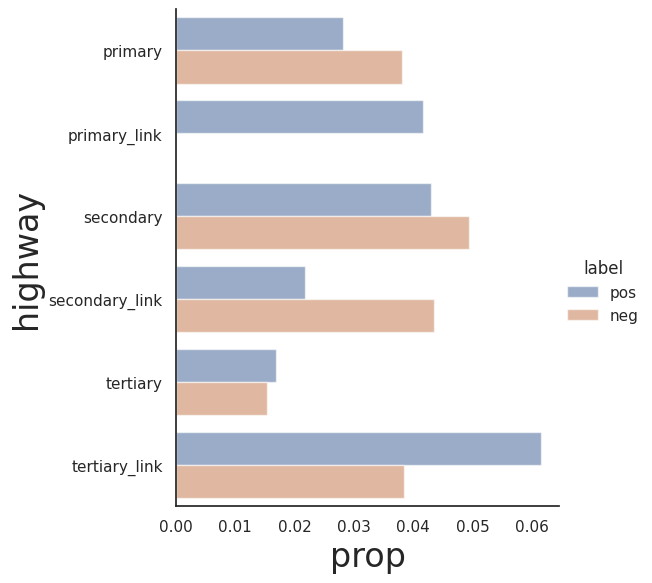

In [65]:
g = sns.catplot(
    data= pos_neg_highway[[simplified_filter(hw) for hw 
                            in pos_neg_highway["highway"]]], 
    kind="bar",
    x="prop", y="highway", hue="label",
    # alette="dark", 
    alpha=.6, height=6
)

In [66]:
# stats of segs with hour > 12
pos_seg_highway_counts = pos_seg_counts[pos_seg_counts['date_hour'] > 12].merge(gdf_edges, on=['u', 'v', 'gkey'], 
                                            how='left').groupby('highway').size().reset_index(name='count')
pos_seg_highway_counts = pos_seg_highway_counts.merge(seg_highway_counts, on='highway', 
                                                        suffixes=['_pos', '_all'])
pos_seg_highway_counts['prop'] = pos_seg_highway_counts['count_pos'] / pos_seg_highway_counts['count_all']

neg_seg_highway_counts = neg_seg_counts[neg_seg_counts['date_hour'] > 12].merge(gdf_edges, on=['u', 'v', 'gkey'], 
                                            how='left').groupby('highway').size().reset_index(name='count')
neg_seg_highway_counts = neg_seg_highway_counts.merge(seg_highway_counts, on='highway', 
                                                        suffixes=['_pos', '_all'])
neg_seg_highway_counts['prop'] = neg_seg_highway_counts['count_pos'] / neg_seg_highway_counts['count_all']

pos_seg_highway_counts['label'] = 'pos'
neg_seg_highway_counts['label'] = 'neg'

pos_neg_highway = pd.concat([pos_seg_highway_counts, neg_seg_highway_counts], axis=0)

In [67]:
# no valid data records

# g = sns.catplot(
#     data= pos_neg_highway[[simplified_filter(hw) for hw 
#                             in pos_neg_highway["highway"]]], 
#     kind="bar",
#     x="prop", y="highway", hue="label",
#     # alette="dark", 
#     alpha=.6, height=6
# )

Are there segments always having big speed difference within day-time?

In [68]:
DAYTIME_START_HOUR=8
DAYTIME_END_HOUR=18
DAYTIME_HOURS = DAYTIME_END_HOUR - DAYTIME_START_HOUR

In [69]:
pos_seg_counts = big_pos_div[(big_pos_div.hour >= DAYTIME_START_HOUR) & (big_pos_div.hour < DAYTIME_END_HOUR)]\
                        .groupby(["u", "v", "gkey"]).\
                        agg({'date_hour': 'count'}).reset_index()
neg_seg_counts = big_neg_div[(big_neg_div.hour >= DAYTIME_START_HOUR) & (big_neg_div.hour < DAYTIME_END_HOUR)]\
                        .groupby(["u", "v", "gkey"]).\
                        agg({'date_hour': 'count'}).reset_index()

In [70]:
pos_seg_counts['date_hour'].describe()

count    11.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: date_hour, dtype: float64

In [71]:
neg_seg_counts['date_hour'].describe()

count    17.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: date_hour, dtype: float64

In [72]:
pos_seg_counts = pos_seg_counts.sort_values("date_hour", ascending=False)
neg_seg_counts = neg_seg_counts.sort_values("date_hour", ascending=False)

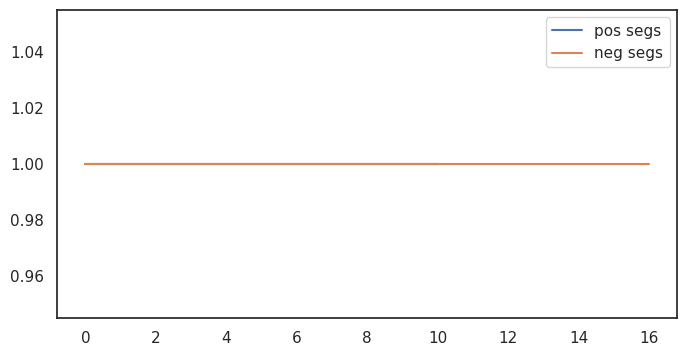

In [73]:
fig, ax = plt.subplots(figsize=(8, 4))

g = ax.plot(range(pos_seg_counts.shape[0]), pos_seg_counts.date_hour, label='pos segs')
g = ax.plot(range(neg_seg_counts.shape[0]), neg_seg_counts.date_hour, label='neg segs')
plt.legend()
plt.show()

In [74]:
print(pos_seg_counts[pos_seg_counts["date_hour"] > DAYTIME_HOURS].shape, 
neg_seg_counts[neg_seg_counts["date_hour"] > DAYTIME_HOURS].shape)

(0, 4) (0, 4)


In [75]:
pos_neg_seg_counts = pos_seg_counts.merge(neg_seg_counts, on=["u", "v", "gkey"], how='inner', suffixes=["_pos","_neg"])
print(pos_neg_seg_counts.shape, pos_seg_counts.shape, neg_seg_counts.shape)

(1, 5) (11, 4) (17, 4)


In [76]:
pos_neg_seg_counts['overlap_hour'] = pos_neg_seg_counts[pos_neg_seg_counts['date_hour_pos'] 
                                                        <= pos_neg_seg_counts['date_hour_neg']]['date_hour_pos']
pos_neg_seg_counts['overlap_hour'] = pos_neg_seg_counts[pos_neg_seg_counts['date_hour_pos'] 
                                                        > pos_neg_seg_counts['date_hour_neg']]['date_hour_neg']

In [77]:
pos_neg_seg_counts['overlap_hour'].max()

nan

In [78]:
pos_neg_seg_counts.sort_values('overlap_hour', ascending = False)

,u,v,gkey,date_hour_pos,date_hour_neg,overlap_hour
0,1311619365,30254222,1311619365_30254222_307933383,1,1,NaN
